In [1]:
import numpy as np
from skimage import color, exposure, transform
from skimage import io
import skimage.data
import skimage.transform
import os
import glob
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Root directory (C:\Users\Administrator)
ROOT_DIR = '.\\traffic\\datasets\\GTSRB_NOISED_ONLY'

# Path to training directory
TRAIN_DATA_DIR = os.path.join(ROOT_DIR, 'Final_Training\\Images\\')

# Path to all training images
ALL_TRAIN_IMG_PATHS = glob.glob(os.path.join(TRAIN_DATA_DIR, '*\\*.ppm'))

# Shuffle training images
np.random.shuffle(ALL_TRAIN_IMG_PATHS)

# Image size
IMG_TARGET_SIZE = 32

# Number of image classes in data set
IMG_CLASSES = 43

# Batch size for training the model
BATCH_SIZE = 32

# Epochs for training the model
EPOCHS = 25

# Learning rate
lr = 0.01

In [3]:
# Preprocess images
def preprocess_img(img):
    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]
    
    # rescale to standard size
    img = transform.resize(img, (IMG_TARGET_SIZE, IMG_TARGET_SIZE), mode='constant')

    return img



# Split Image Path
def get_class(img_path):
    return int(img_path.split('\\')[-2])



# Load dataset from file system
def load_training_data():
    images = []
    labels = []
    
    for img_path in ALL_TRAIN_IMG_PATHS:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        images.append(img)
        labels.append(label)
    return images, labels



# Display the first image of each label
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

    
    
# Display images of a specific label
def display_images_of_label(images, label):
    # show a max of 24 images
    limit = 24
    
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        # 3 rows, 8 per row
        plt.subplot(3, 8, i)
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()
    

    
# Display image shape
def display_image_shape(images):
    for image in images[:5]:
        print("shape: {0}".format(image.shape))



def schedule_learning_rate(epoch):
    return lr * (0.1 ** int(epoch / 10))

In [4]:
now = datetime.datetime.now()
print("Load Dataset: ")
print(now.strftime("%Y-%m-%d %H:%M"))
print()

# Load training dataset
images, labels = load_training_data()

now = datetime.datetime.now()
print("Loaded Dataset: ")
print(now.strftime("%Y-%m-%d %H:%M"))

Load Dataset: 
2018-02-28 10:51

Loaded Dataset: 
2018-02-28 10:53


In [5]:
# How many images and labels do we have?
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 43
Total Images: 78418


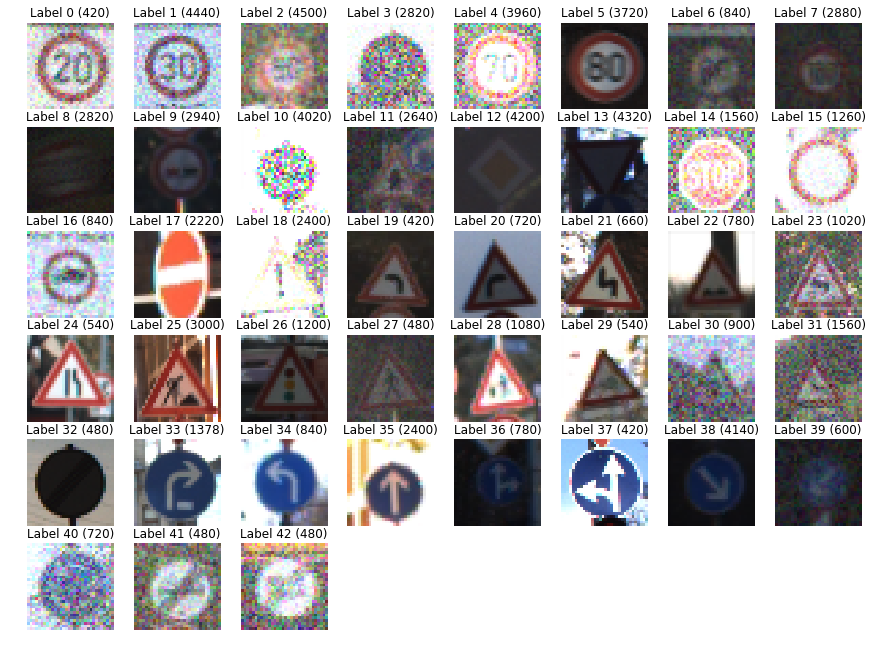

shape: (32, 32, 3)
shape: (32, 32, 3)
shape: (32, 32, 3)
shape: (32, 32, 3)
shape: (32, 32, 3)


In [6]:
# Display the first image of each label
display_images_and_labels(images, labels)

display_image_shape(images)

In [7]:
X = np.array(images, dtype='float32')

# Make one hot targets
Y = np.eye(IMG_CLASSES, dtype='uint8')[labels]

In [8]:
# Model of 'Convolutional Neural Network'
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='valid', data_format="channels_last", input_shape=(IMG_TARGET_SIZE, IMG_TARGET_SIZE, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(IMG_CLASSES, activation='softmax'))
    return model

In [9]:
model = cnn_model()

In [10]:
print("Epochs: ", EPOCHS)
print("Batch Size: ", BATCH_SIZE)

Epochs:  50
Batch Size:  32


In [11]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('logger_GTSRB_NOISED_ONLY_vm.csv', append=True, separator=';')

model.fit(X, Y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.2,
          shuffle=True,
          callbacks=[LearningRateScheduler(schedule_learning_rate),
                     ModelCheckpoint('Model_GTSRB_NOISED_ONLY_vm.h5', save_best_only=True),
                     csv_logger]
          )

Train on 62734 samples, validate on 15684 samples
Epoch 1/50
62734/62734 [==============================] - 776s 12ms/step - loss: 1.9449 - acc: 0.4359 - val_loss: 0.3496 - val_acc: 0.8932
Epoch 2/50
62734/62734 [==============================] - 761s 12ms/step - loss: 0.3784 - acc: 0.8847 - val_loss: 0.1763 - val_acc: 0.9482
Epoch 3/50
62734/62734 [==============================] - 758s 12ms/step - loss: 0.2358 - acc: 0.9301 - val_loss: 0.1154 - val_acc: 0.9657
Epoch 4/50
19712/62734 [========>.....................] - ETA: 8:11 - loss: 0.2037 - acc: 0.9400

KeyboardInterrupt: 

In [ ]:
test = pd.read_csv('.\\traffic\\datasets\\GT-final_test.csv', sep=';')

# Load test dataset
X_test = []
y_test = []
i = 0

for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('.\\traffic\\datasets\\GTSRB_NOISED_ONLY\\Final_Test\\Images', file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)

X_test = np.array(X_test)
y_test = np.array(y_test)

# predict and evaluate
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred == y_test) / np.size(y_pred)
print("Test accuracy = {}".format(acc))

In [ ]:
model.summary()

In [ ]:
model.count_params()